In [815]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [816]:
class unknown_dist:
    def __init__(self, type, degree = 1):
        self.type = type
        match self.type:
            case 'polynomial':
                self.degree = degree
                self.coefs = 2 * np.random.rand(self.degree + 1, 1) - 1
            case 'sigmoid':
                self.degree = degree
                self.coefs = np.random.rand(1) - 0.5
            case 'sin':
                self.degree = degree
                self.amp = np.random.rand(1) - 0.5
                self.freq = np.random.rand(1) - 0.5
            
    def sample(self, x):
        match self.type:
            case 'polynomial':
                x_ = np.power(x, np.arange(self.degree + 1))
                return np.dot(x_, self.coefs)
            case 'sigmoid':
                return 1/(1+np.exp(-x))
            case 'sin':
                return self.amp * np.sin(self.freq * x)
    
    @staticmethod
    def noise(x):
        return 0.1 * np.random.normal(0, 1, size=np.shape(x))

In [817]:
class lr_group:
    def __init__(self, disttype='polynomial', bound=10, distorder=3, maxpoly=10, samplesperstep=5, tt_ratio = 0.2):
        self.disttype = disttype
        self.bound  = bound
        self.distorder = distorder
        self.maxpoly = maxpoly
        self.sps = samplesperstep

        self.tt_ratio = tt_ratio

        self.dist = unknown_dist(self.disttype, degree = self.distorder)

        # self.linreg_models = [linear_model.LinearRegression() for _ in range(self.maxpoly)]
        self.linreg_models = [linear_model.Ridge(alpha=1.0) for _ in range(self.maxpoly)]

        self.x = np.zeros((1, self.maxpoly+1))
        self.y = np.zeros((1, 1))

        self.rms_history = np.zeros((1, self.maxpoly))
        self.cod_history = np.zeros((1, self.maxpoly))

    def step(self):
        xs = np.random.uniform(-self.bound, self.bound, self.sps).reshape(self.sps, 1)
        xs = np.power(xs, np.arange(self.maxpoly + 1))

        y_temp = np.zeros((self.sps, 1))

        x_ = xs[:, 1:2]
        ys = self.dist.sample(x_) + self.dist.noise(x_)

        self.x = np.append(self.x, xs, axis=0)
        self.y = np.append(self.y, ys, axis=0)

    def train(self):
        random_perm = np.random.permutation(range(1, np.shape(self.x)[0]))
        split = int(self.tt_ratio * np.shape(self.x)[0])

        x_train = self.x[random_perm[:-split]]
        x_test = self.x[random_perm[-split:]]
        y_train = self.y[random_perm[:-split]]
        y_test = self.y[random_perm[-split:]]

        rms_temp = np.zeros((1, self.maxpoly))
        cod_temp = np.zeros((1, self.maxpoly))
        for degree, lrm in enumerate(self.linreg_models):
            if degree != 0:
                lrm.fit(x_train[:, 0:degree+1], y_train[:, 0])

                x_in = x_test[:, 0:degree+1]
                y_pred = lrm.predict(x_in)

                rms_temp[0, degree] = mean_squared_error(y_test[:, 0], y_pred)
                cod_temp[0, degree] = r2_score(y_test[:, 0], y_pred)

        self.rms_history = np.append(self.rms_history, rms_temp, axis=0)
        self.cod_history = np.append(self.cod_history, cod_temp, axis=0)
        
        

Linear Regression Training

Randomly sample an unknown distribution (polynomial, sigmoid, and sin implemented)
Using 5 samples per step, fit polynomial curves using ridge regression method (train/test split is 4:1 by default) and record mean squared error and coefficient of determination

Every iteration, add 5 new data points and fit linear regressions to whole data set.

In [818]:
lrg = lr_group(disttype='sigmoid', bound=5, distorder=4, maxpoly=10, samplesperstep=5)

maxsteps = 100
for _ in range(maxsteps):
    lrg.step()
    lrg.train()

c:\Users\bluej\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\bluej\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\bluej\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\bluej\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\bluej\AppData\Local\Programs\Python\Python3

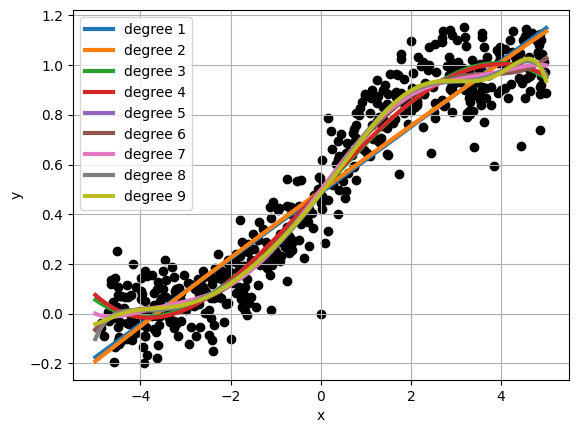

In [819]:
n_f = 200
funcspacebase = np.linspace(-lrg.bound, lrg.bound, n_f).reshape(n_f, 1)

for degree, lrm in enumerate(lrg.linreg_models):
    if degree == 0:
        pass
    else:
        funcspace = np.power(funcspacebase, np.arange(degree + 1))
        plt.plot(funcspace[:,1], lrm.predict(funcspace), linewidth=3, label='degree {}'.format(degree))
plt.scatter(lrg.x[:, 1], lrg.y, color="black")
plt.xlabel("x")
plt.ylabel("y")

plt.legend()
plt.grid()
plt.show()

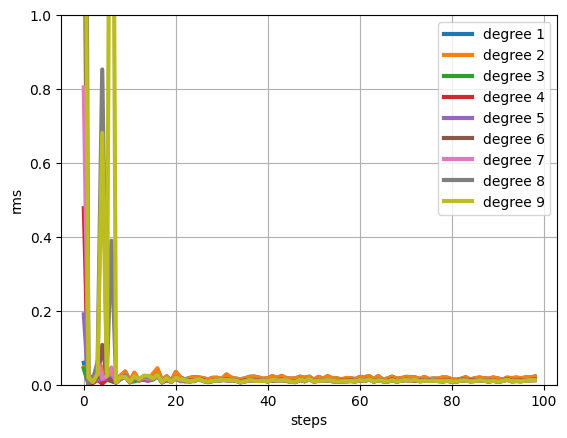

In [820]:
steprange = 100
for degree, lrm in enumerate(lrg.linreg_models):
    if degree == 0:
        pass
    else:
        plt.plot(range(steprange-1), lrg.rms_history[1:steprange, degree], linewidth=3, label='degree {}'.format(degree))
plt.xlabel("steps")
plt.ylabel("rms")
plt.ylim([0, 1])

plt.legend()
plt.grid()
plt.show()

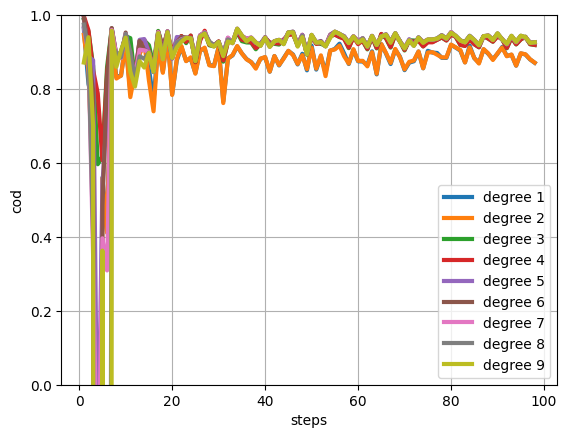

In [821]:
for degree, lrm in enumerate(lrg.linreg_models):
    if degree == 0:
        pass
    else:
        plt.plot(range(steprange-1), lrg.cod_history[1:steprange, degree], linewidth=3, label='degree {}'.format(degree))
plt.xlabel("steps")
plt.ylabel("cod")

plt.ylim([0, 1])
plt.legend()
plt.grid()